In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def load_and_prepare_data(filepath): 
    df = pd.read_csv(filepath)
    date_str, time_str = val.strip().split()
    if time_str == "24:00:00":
        month, day = map(int, date_str.split("/"))
        new_date = pd.Timestamp(year=2020, month=month, day=day) + pd.Timedelta(days=1)
        return new_date.replace(hour=0, minute=0, second=0)
    else:
        return pd.to_datetime(f"2020/{date_str} {time_str}", format="%Y/%m/%d %H:%M:%S")
    
    # Fix Date/Time column and add Month
    df['Date/Time'] = df['Date/Time'].apply(fix_datetime)
    df['Month'] = df['Date/Time'].dt.month
    df_data = df.drop(columns=["Date/Time"]).copy()
    df_data = df_data.apply(pd.to_numeric, errors='coerce')
    df_data['Month'] = df['Month']
    return df, df_data
    
def process_energy_data(csv_file, verbose=True):
    df = pd.read_csv(csv_file)
    
    # Print the column names for debugging if verbose is True.
    if verbose:
        print(f"\nColumns in {csv_file}:")
        print(df.columns.tolist())
    
    # Identify a Date/Time column (using any column that contains "Date" or "Time").
    date_time_col = None
    for col in df.columns:
        if "Date" in col or "Time" in col:
            date_time_col = col
            break
    
    if date_time_col is None:
        raise ValueError(f"No suitable Date/Time column found in {csv_file}")
    
    # Rename the detected Date/Time column for consistency.
    df.rename(columns={date_time_col: 'Date/Time'}, inplace=True)
    
    # Fix the 24:00:00 issue and convert the 'Date/Time' column.
    df['Date/Time'] = df['Date/Time'].str.replace(' 24:00:00', ' 00:00:00', regex=False)
    df['Date/Time'] = pd.to_datetime('2023 ' + df['Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')
    df.dropna(subset=['Date/Time'], inplace=True)
    return df

def process_metering_data(csv_file, verbose=True):
    """
    Reads the metered data and converts the date/time column to a datetime object.
    """
    df = pd.read_csv(csv_file)
    
    # Print the columns to debug header issues if verbose is True
    if verbose:
        print(f"\nColumns in {csv_file}:")
        print(df.columns.tolist())
    
    # Determine the timestamp column (rename if necessary)
    timestamp_col = None
    if 'Timestamp' in df.columns:
        timestamp_col = 'Timestamp'
    else:
        for col in df.columns:
            if "Date" in col or "Time" in col:
                timestamp_col = col
                df.rename(columns={col: 'Timestamp'}, inplace=True)
                break
        if timestamp_col is None:
            raise ValueError(f"No suitable Timestamp/Date column found in {csv_file}")

    # Convert the Timestamp column to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df.dropna(subset=['Timestamp'], inplace=True)
    return df

def remap_simulation_name(sim_name, simulation_name_map=None):

    if simulation_name_map and sim_name in simulation_name_map:
        return simulation_name_map[sim_name]
    return sim_name

group_order = ['Electricity', 'Heating', 'Cooling']
granularity_order = ['y', 'm', 'w', 'd', 'h']

def sort_key(col_name):
    # Extract group and granularity using split
    # Expected format: 'EUI$_{Group|Granularity}$'
    try:
        inner = col_name.split('$_{')[1].split('}$')[0]  # e.g., 'Electricity|y'
        group, granularity = inner.split('|')
        group_idx = group_order.index(group)
        granularity_idx = granularity_order.index(granularity)
        return (group_idx, granularity_idx)
    except Exception as e:
        # Put unknown formats at the end
        return (len(group_order), len(granularity_order))

In [56]:
def breakdown_multifrequency_metrics(parent_folders, metered_csv, start_date, end_date, area, 
                                       simulation_name_map=None, print_metric="CVRMSE", 
                                       export_dir=None, verbose=True):
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    printer = print if verbose else lambda *args, **kwargs: None

    if export_dir:
        os.makedirs(export_dir, exist_ok=True)

    def compute_rmse(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return np.sqrt(mean_squared_error(resampled[met_col], resampled[sim_col]))

    def compute_cvrmse(df, freq_rule, sim_col, met_col):
        rmse = compute_rmse(df, freq_rule, sim_col, met_col)
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (rmse / mean_met) * 100

    def compute_mae(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return mean_absolute_error(resampled[met_col], resampled[sim_col])

    def compute_mape(df, freq_rule, sim_col, met_col):
        # Resample and sum the data
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        
        # Drop rows where `met_col` is 0 or NA
        resampled = resampled.dropna(subset=[met_col])  # Remove NA
        resampled = resampled[resampled[met_col] != 0]  # Remove zeros
        
        # Check if the filtered DataFrame is empty
        if resampled.empty:
            return None
        
        # Compute MAPE
        errors = np.abs((resampled[met_col] - resampled[sim_col]) / resampled[met_col])
        return np.mean(errors) * 100
    
    def compute_nmbe(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (resampled[sim_col] - resampled[met_col]).mean() / mean_met * 100

    sim_start, sim_end = pd.to_datetime(start_date), pd.to_datetime(end_date)

    df_met = process_metering_data(metered_csv, verbose)
    df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
    df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
    df_met.sort_values('Timestamp', inplace=True)
    for metric in ['Electricity', 'Heating', 'Cooling']:
        df_met[f'{metric}_norm'] = df_met[f'Main {metric}'] / area
    df_met.set_index('Timestamp', inplace=True)

    freq_map = {'y':'Y','m':'M','w':'W','d':'D','h':'h'}

    metric_funcs = {'RMSE':compute_rmse,'CVRMSE':compute_cvrmse,'MAE':compute_mae,'MAPE':compute_mape,'NMBE':compute_nmbe}
    metric_dfs = {metric:[] for metric in metric_funcs}

    for folder in parent_folders:
        for sim in os.listdir(folder):
            sim_path = os.path.join(folder, sim, 'eplusmtr.csv')
            if os.path.exists(sim_path):
                df_sim = process_energy_data(sim_path, verbose)
                df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]

                df_sim['Electricity_norm'] = (
                    df_sim['Electricity:Facility [J](Hourly)'] -
                    df_sim.get('Heating:Electricity [J](Hourly)',0)-
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Heating_norm'] = (
                    df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                    df_sim.get('Heating:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Cooling_norm'] = (
                    df_sim['DistrictCooling:Facility [J](Hourly)'] +
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)

                merged = pd.merge(df_sim, df_met,left_on='Date/Time',right_index=True,suffixes=('_sim','_met'))
                merged.index = merged['Date/Time']
                sim_name = remap_simulation_name(sim, simulation_name_map)

                for metric, func in metric_funcs.items():
                    result_row = {'Simulation':sim_name}
                    for freq_label, freq_rule in freq_map.items():
                        for var in ['Electricity','Heating','Cooling']:
                            col_label = f'EUI$_{{{var}|{freq_label}}}$'
                            result_row[col_label] = func(merged,freq_rule,f'{var}_norm_sim',f'{var}_norm_met')
                    metric_dfs[metric].append(result_row)

    result_dfs = {}
    for metric, rows in metric_dfs.items():
        df = pd.DataFrame(rows).set_index('Simulation').round(2)
        result_dfs[metric] = df
        if metric.upper()==print_metric.upper():
            printer(f"\nComputed {metric.upper()} at multiple frequencies:", list(df.columns))

    return (result_dfs['CVRMSE'], result_dfs['RMSE'], result_dfs['MAE'], result_dfs['MAPE'], result_dfs['NMBE'])

parent_folders = ['2025-Apr15']
metered_csv = 'Metering.csv'
start_date = '2023-01-01'
end_date = '2024-01-01'
area = 8894


simulation_name_map = {
    "gh-Detailed-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_03Detailed",
    "gh-Ideal-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_01Ideal",
    "gh-Lumped-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_02Lumped",
} 

export_dir = "./exported_metrics"
multifreq_cvrmse_df, multifreq_rmse_df, multifreq_mae_df, multifreq_mape_df, multifreq_nmbe_df = breakdown_multifrequency_metrics(
    parent_folders, 
    metered_csv, 
    start_date, 
    end_date, 
    area, 
    simulation_name_map=simulation_name_map,
    verbose=False,
    export_dir='1'
)

multifreq_cvrmse_df = multifreq_cvrmse_df[sorted(multifreq_cvrmse_df.columns, key=sort_key)]
multifreq_rmse_df= multifreq_rmse_df[sorted(multifreq_rmse_df.columns, key=sort_key)]
multifreq_mape_df= multifreq_mape_df[sorted(multifreq_mape_df.columns, key=sort_key)]
multifreq_mae_df= multifreq_mae_df[sorted(multifreq_mae_df.columns, key=sort_key)]
multifreq_nmbe_df= multifreq_nmbe_df[sorted(multifreq_nmbe_df.columns, key=sort_key)]


In [57]:
multifreq_cvrmse_df

,EUI$_{Electricity|y}$,EUI$_{Electricity|m}$,EUI$_{Electricity|w}$,EUI$_{Electricity|d}$,EUI$_{Electricity|h}$,EUI$_{Heating|y}$,EUI$_{Heating|m}$,EUI$_{Heating|w}$,EUI$_{Heating|d}$,EUI$_{Heating|h}$,EUI$_{Cooling|y}$,EUI$_{Cooling|m}$,EUI$_{Cooling|w}$,EUI$_{Cooling|d}$,EUI$_{Cooling|h}$
Simulation,,,,,,,,,,,,,,,
Performance-Requirements_02Manual | HVAC-Model-Structure_03Detailed,18.96,19.68,21.01,42.51,76.06,72.35,85.04,90.34,100.41,136.15,279.72,360.13,366.22,394.90,489.20
Performance-Requirements_01Standards | HVAC-Model-Structure_03Detailed,19.05,19.78,21.10,42.61,76.20,70.91,83.27,88.69,98.58,131.34,233.23,318.37,324.80,349.31,437.79
Performance-Requirements_03Reality | HVAC-Model-Structure_03Detailed,19.16,19.89,21.20,42.72,76.40,68.64,80.62,86.22,95.85,126.58,195.93,285.10,291.88,313.77,401.78
Performance-Requirements_02Manual | HVAC-Model-Structure_01Ideal,7.76,8.97,11.30,38.13,72.65,69.54,81.47,86.82,97.82,134.98,80.08,92.68,106.04,122.32,195.38
Performance-Requirements_01Standards | HVAC-Model-Structure_01Ideal,7.76,8.97,11.30,38.13,72.65,67.10,78.58,84.07,95.02,127.63,82.71,95.43,108.34,123.79,191.71
Performance-Requirements_03Reality | HVAC-Model-Structure_01Ideal,7.76,8.97,11.30,38.13,72.65,63.41,74.40,80.12,90.79,121.79,84.81,97.76,110.27,124.90,190.43
Performance-Requirements_02Manual | HVAC-Model-Structure_02Lumped,18.96,19.68,21.01,42.51,76.06,72.64,85.38,90.68,100.71,136.35,277.52,359.35,365.48,394.42,488.92
Performance-Requirements_01Standards | HVAC-Model-Structure_02Lumped,19.05,19.78,21.10,42.61,76.20,71.21,83.60,89.02,98.88,131.55,231.08,317.83,324.31,349.03,437.75
Performance-Requirements_03Reality | HVAC-Model-Structure_02Lumped,19.16,19.89,21.20,42.72,76.40,68.92,80.94,86.54,96.14,126.76,193.90,284.72,291.56,313.63,401.79


In [58]:
def generate_eui_table(parent_folders, metered_csv, start_date, end_date, area, 
                       simulation_name_map=None, verbose=True):
    import os
    import pandas as pd

    # Define a printer that only prints if verbose is True.
    printer = print if verbose else lambda *args, **kwargs: None

    sim_start = pd.to_datetime(start_date)
    sim_end = pd.to_datetime(end_date)
    
    # --- Process Metered Data ---
    metered_results = None
    if metered_csv and os.path.exists(metered_csv):
        try:
            df_met = process_metering_data(metered_csv, verbose=verbose)
            df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
            df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
            df_met.sort_values('Timestamp', inplace=True)
            # Normalize metered data (assuming the raw data are in appropriate energy units)
            df_met['Electricity_norm'] = df_met['Main Electricity'] / area
            df_met['Heating_norm']     = df_met['Main Heating'] / area
            df_met['Cooling_norm']     = df_met['Main Cooling'] / area
            df_met.set_index('Timestamp', inplace=True)
            metered_results = df_met
            printer(f"Metered data loaded for EUI calculation. Columns: {list(metered_results.columns)}")
        except Exception as e:
            printer(f"Error processing metered data: {e}")
            return None
    else:
        printer(f"Metered CSV file {metered_csv} not found.")
        return None

    # Resample metered data to annual totals.
    met_ann = metered_results.resample('A').sum()
    if met_ann.empty:
        printer("No metered data available after resampling.")
        return None

    # Assume one annual period and extract values.
    met_elec = met_ann['Electricity_norm'].iloc[0]
    met_heat = met_ann['Heating_norm'].iloc[0]
    met_cool = met_ann['Cooling_norm'].iloc[0]
    met_eui  = met_elec + met_heat + met_cool

    # --- Process Simulation Data ---
    simulation_eui_list = []

    for parent_folder in parent_folders:
        printer(f"Processing simulation folders in: {parent_folder}")
        for child in os.listdir(parent_folder):
            full_path = os.path.join(parent_folder, child)
            if os.path.isdir(full_path):
                energy_file = None
                for file in os.listdir(full_path):
                    if file == "eplusmtr.csv":
                        energy_file = os.path.join(full_path, file)
                        break
                if energy_file:
                    printer(f"  Processing simulation: {energy_file}")
                    try:
                        df_sim = process_energy_data(energy_file, verbose=verbose)
                        df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                        df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]
                        df_sim.sort_values('Date/Time', inplace=True)
                        # Compute normalized simulation values with conversion to appropriate units.
                        df_sim['Electricity_norm'] = (
                            df_sim['Electricity:Facility [J](Hourly)'] -
                            df_sim.get('Heating:Electricity [J](Hourly)', 0) -
                            df_sim.get('Cooling:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        df_sim['Heating_norm'] = (
                            df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                            df_sim.get('Heating:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        df_sim['Cooling_norm'] = (
                            df_sim['DistrictCooling:Facility [J](Hourly)'] +
                            df_sim.get('Cooling:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        # Set index to Date/Time so that we can resample.
                        df_sim.set_index('Date/Time', inplace=True)
                        sim_ann = df_sim.resample('A').sum()
                        if sim_ann.empty:
                            printer(f"    No annual data for simulation '{child}', skipping.")
                            continue
                        # Extract annual totals (assuming a single year within the filtered period)
                        sim_elec = sim_ann['Electricity_norm'].iloc[0]
                        sim_heat = sim_ann['Heating_norm'].iloc[0]
                        sim_cool = sim_ann['Cooling_norm'].iloc[0]
                        sim_eui  = sim_elec + sim_heat + sim_cool
                        
                        # Optionally remap the simulation folder name.
                        sim_display_name = remap_simulation_name(child, simulation_name_map)
                        simulation_eui_list.append({
                            'Simulation': sim_display_name,
                            'EUI$_{Electricity|y}$': round(sim_elec, 2),
                            'EUI$_{Heating|y}$': round(sim_heat, 2),
                            'EUI$_{Cooling|y}$': round(sim_cool, 2),
                            'EUI$_{Total|y}$':  round(sim_eui, 2)
                        })
                    except Exception as e:
                        printer(f"    Error processing simulation '{child}': {e}")
                else:
                    printer(f"  No eplusmtr.csv found in {full_path}")

    # Create a DataFrame for simulation results.
    if simulation_eui_list:
        sim_eui_df = pd.DataFrame(simulation_eui_list)
        sim_eui_df.set_index('Simulation', inplace=True)
    else:
        printer("No simulation data processed for EUI.")
        return None

    # --- Append Metered Data ---
    # Create a DataFrame row for the metered data using "Metered" as the index.
    # And update the metered row creation:
    metered_row = pd.DataFrame({
        'EUI$_{Electricity|y}$': [round(met_elec, 2)],
        'EUI$_{Heating|y}$': [round(met_heat, 2)],
        'EUI$_{Cooling|y}$': [round(met_cool, 2)],
        'EUI$_{Total|y}$':  [round(met_eui, 2)]
    }, index=["Metered"])

    final_eui_df = pd.concat([sim_eui_df, metered_row])
    
    printer(f"\nGenerated EUI Table. Columns: {list(final_eui_df.columns)}")
    return final_eui_df

eui_table_df = generate_eui_table(
    parent_folders, 
    metered_csv, 
    start_date, 
    end_date, 
    area, 
    simulation_name_map=simulation_name_map, 
    verbose=False  # Change to False to disable all prints.
)

### HeatMap

In [102]:
def plot_2d_kpi_visualization(kpi_df, simulation_name_map, granularity_filter=None, 
                             kpi_name='CVRMSE', show_values=True, grid_lines=True):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract descriptive parameters
    para1_values = []
    para2_values = []
    para1_labels = []
    para2_labels = []
    for sim_name in kpi_df.index:
        descriptive_name = simulation_name_map.get(sim_name, sim_name)
        parts = descriptive_name.split(' | ')
        para1_values.append(parts[0])
        para2_values.append(parts[1])
        para1_labels.append(parts[0].split('_')[-1])
        para2_labels.append(parts[1].split('_')[-1])
    
    # Convert to numerical indices
    para1_unique = sorted(list(set(para1_values)))
    para2_unique = sorted(list(set(para2_values)))
    para1_label = para1_unique[0].split('_')[0].replace('-', ' ')
    para2_label = para2_unique[0].split('_')[0].replace('-', ' ')
    
    para1_map = {val: idx for idx, val in enumerate(para1_unique)}
    para2_map = {val: idx for idx, val in enumerate(para2_unique)}
    x = np.array([para1_map[val] for val in para1_values])
    y = np.array([para2_map[val] for val in para2_values])

    # Handle granularity filter
    if granularity_filter is None:
        target_frequencies = ['h']  # Default to hourly
    else:
        target_frequencies = granularity_filter
    # Take the first frequency in the filter for subplots
    freq = target_frequencies[0] if target_frequencies else 'h'

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))
    fig.subplots_adjust(wspace=0.4, right=0.88)
    
    for ax_idx, end_use in enumerate(['Electricity', 'Heating', 'Cooling']):
        ax = axes[ax_idx]
        # Find the column corresponding to the end_use and selected frequency
        col_pattern = f'{{{end_use}|{freq}}}'
        col = next((c for c in kpi_df.columns if col_pattern in c), None)
        if not col:
            continue
            
        z_vals = kpi_df[col].values
        vmin, vmax = np.nanmin(z_vals), np.nanmax(z_vals)
        norm = plt.Normalize(vmin, vmax)
        cmap = plt.cm.viridis
        
        # Calculate sizes relative to subplot's value range
        sizes = (z_vals - vmin) / (vmax - vmin + 1e-8) * 500 + 50
        
        # Create scatter plot
        scatter = ax.scatter(
            x, y,
            c=z_vals,
            cmap=cmap,
            norm=norm,
            s=sizes,
            alpha=0.7,
            edgecolors='w',
            linewidths=0.5
        )
        
        # Add individual colorbar
        cbar = fig.colorbar(scatter, ax=ax, fraction=0.05, pad=0.04)
        cbar.set_label(f'{kpi_name} (%)', fontsize=10)
        
        # Add value annotations
        if show_values:
            for xi, yi, zi in zip(x, y, z_vals):
                ax.text(xi, yi-0.1, f'{zi:.2f}', 
                        ha='center', va='top', 
                        fontsize=8, color='black')
        
        ax.set_title(f"{end_use} ({kpi_name}, {freq.upper()})", fontsize=14, pad=15)
        ax.set_xticks(np.arange(len(para1_unique)))
        ax.set_xticklabels([v.split('_')[-1] for v in para1_unique], 
                        rotation=0,  # Changed from 0 to 45 degrees for better readability
                        ha='center', 
                        fontsize=10,
                        rotation_mode='anchor')  # Added rotation mode
        
        ax.set_yticks(np.arange(len(para2_unique)))
        ax.set_yticklabels([v.split('_')[-1] for v in para2_unique], 
                        rotation=0,  # Changed from 0 to 45 degrees
                        ha='right', 
                        fontsize=10,
                        rotation_mode='anchor')  # Added rotation mode
        
        # Add margin to prevent cutoff
        ax.margins(x=0.15, y=0.15)  # Increased from default 0.05
        
        # Add dashed grid lines
        if grid_lines:
            ax.grid(True, linestyle='--', alpha=0.3, color='gray')
            ax.set_axisbelow(True)
        
        ax.set_xlabel(para1_label, fontsize=12, labelpad=10)
        ax.set_ylabel(para2_label if ax_idx == 0 else '', fontsize=12, labelpad=10)


    
    # [Rest of the code remains the same until tight_layout]
    plt.tight_layout(pad=5.0)
    plt.show()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_eui_visualization(eui_df, simulation_name_map, show_values=True, grid_lines=True):
    """
    Customized 2D visualization for annual EUI values
    """
    # Verify required columns exist
    # Corrected column name formatting
    required_columns = [f'EUI$_{{{end_use}|y}}$' for end_use in ['Electricity', 'Heating', 'Cooling']]
    missing = [col for col in required_columns if col not in eui_df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    para1_values, para2_values = [], []
    para1_labels, para2_labels = [], []
    
    for sim_name in eui_df.index:
        if sim_name == "Metered":  # Handle special meter case
            para1_values.append("Metered")
            para2_values.append("Metered")
            para1_labels.append("Metered")
            para2_labels.append("Metered")
            continue
            
        descriptive_name = simulation_name_map.get(sim_name, sim_name)
        parts = descriptive_name.split(' | ')
        para1_values.append(parts[0])
        para2_values.append(parts[1])
        para1_labels.append(parts[0].split('_')[-1])
        para2_labels.append(parts[1].split('_')[-1])

    # Convert to numerical indices
    para1_unique = sorted(list(set(para1_values)), key=lambda x: (x != "Metered", x))
    para2_unique = sorted(list(set(para2_values)), key=lambda x: (x != "Metered", x))
    
    para1_map = {val: idx for idx, val in enumerate(para1_unique)}
    para2_map = {val: idx for idx, val in enumerate(para2_unique)}
    
    x = np.array([para1_map[val] for val in para1_values])
    y = np.array([para2_map[val] for val in para2_values])

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))
    fig.subplots_adjust(wspace=0.4)
    
    # Define energy components to plot (excluding Total)
    end_uses = ['Electricity', 'Heating', 'Cooling']
    
    for ax_idx, end_use in enumerate(end_uses):
        ax = axes[ax_idx]
        col = f'EUI$_{{{end_use}|y}}$'  # Annual EUI column format

        z_vals = eui_df[col].values
        vmin, vmax = np.nanmin(z_vals), np.nanmax(z_vals)
        norm = plt.Normalize(vmin, vmax)
        cmap = plt.cm.viridis
        
        # Size scaling within component's range
        sizes = (z_vals - vmin)/(vmax - vmin + 1e-8) * 500 + 50
        
        # Create scatter plot
        scatter = ax.scatter(
            x, y,
            c=z_vals,
            cmap=cmap,
            norm=norm,
            s=sizes,
            alpha=0.7,
            edgecolors='w',
            linewidths=0.5
        )
        
        # Add colorbar
        cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'{end_use} EUI (kWh/m²)', fontsize=10)
        
        # Value annotations
        if show_values:
            for xi, yi, zi in zip(x, y, z_vals):
                ax.text(xi, yi-0.15, f'{zi:.1f}', 
                        ha='center', va='top', 
                        fontsize=8, color='black')
        
        # Axis configuration
        ax.set_title(f"Annual {end_use} EUI", fontsize=14, pad=15)
        ax.set_xticks(np.arange(len(para1_unique)))
        ax.set_xticklabels([v.split('_')[-1] if v != "Metered" else "Metered" 
                          for v in para1_unique], 
                          rotation=0, ha='center', fontsize=10)
        
        ax.set_yticks(np.arange(len(para2_unique)))
        y_labels = [v.split('_')[-1] if v != "Metered" else "Metered" 
                   for v in para2_unique]
        ax.set_yticklabels(y_labels, 
                          rotation=0, ha='right', fontsize=10)
        
        # Grid lines
        if grid_lines:
            ax.grid(True, linestyle='--', alpha=0.3, color='gray')
            ax.set_axisbelow(True)
        
        ax.set_xlabel("Performance Standard", 
                     fontsize=12, labelpad=10)
        ax.set_ylabel("HVAC Model" if ax_idx == 0 else "", 
                     fontsize=12, labelpad=10)
        ax.margins(x=0.15, y=0.15)  # Increased margins
    fig.subplots_adjust(wspace=2, right=0.5)
    plt.tight_layout(pad=5.0)
    plt.show()

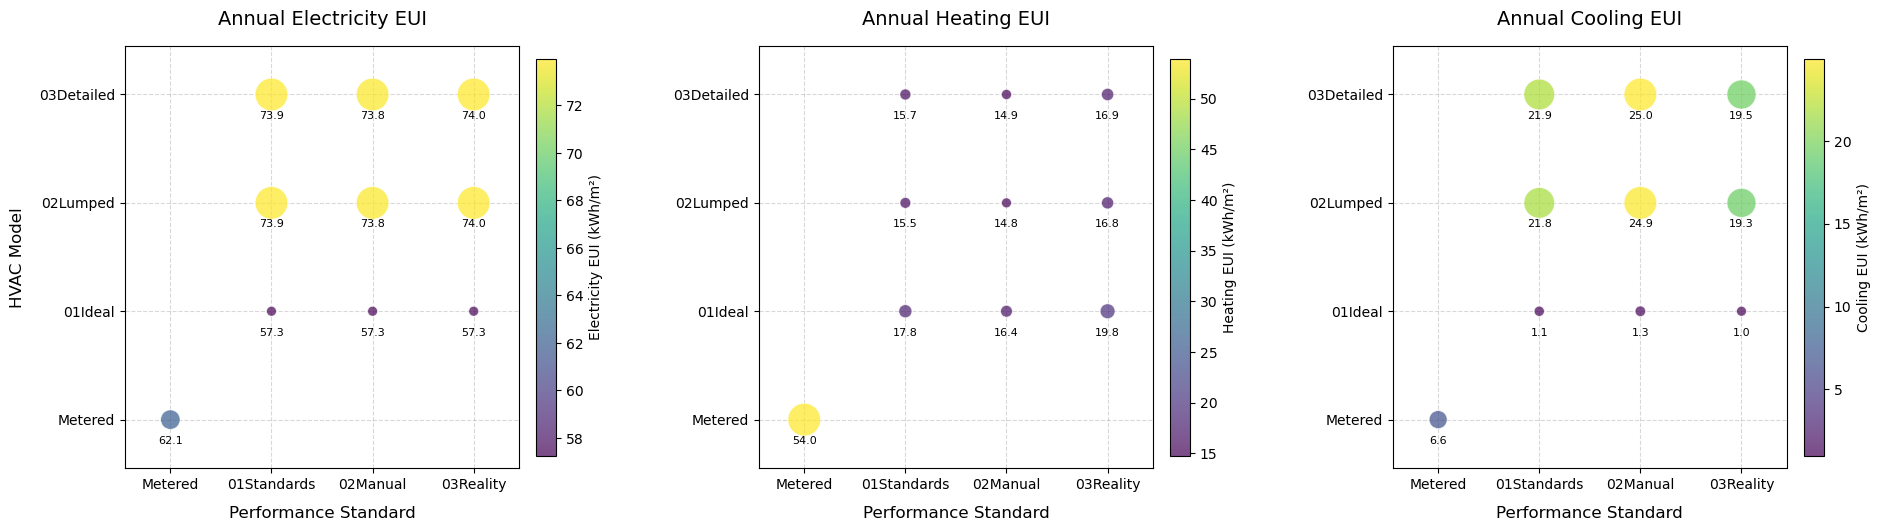

In [ ]:
plot_eui_visualization(eui_table_df, simulation_name_map)

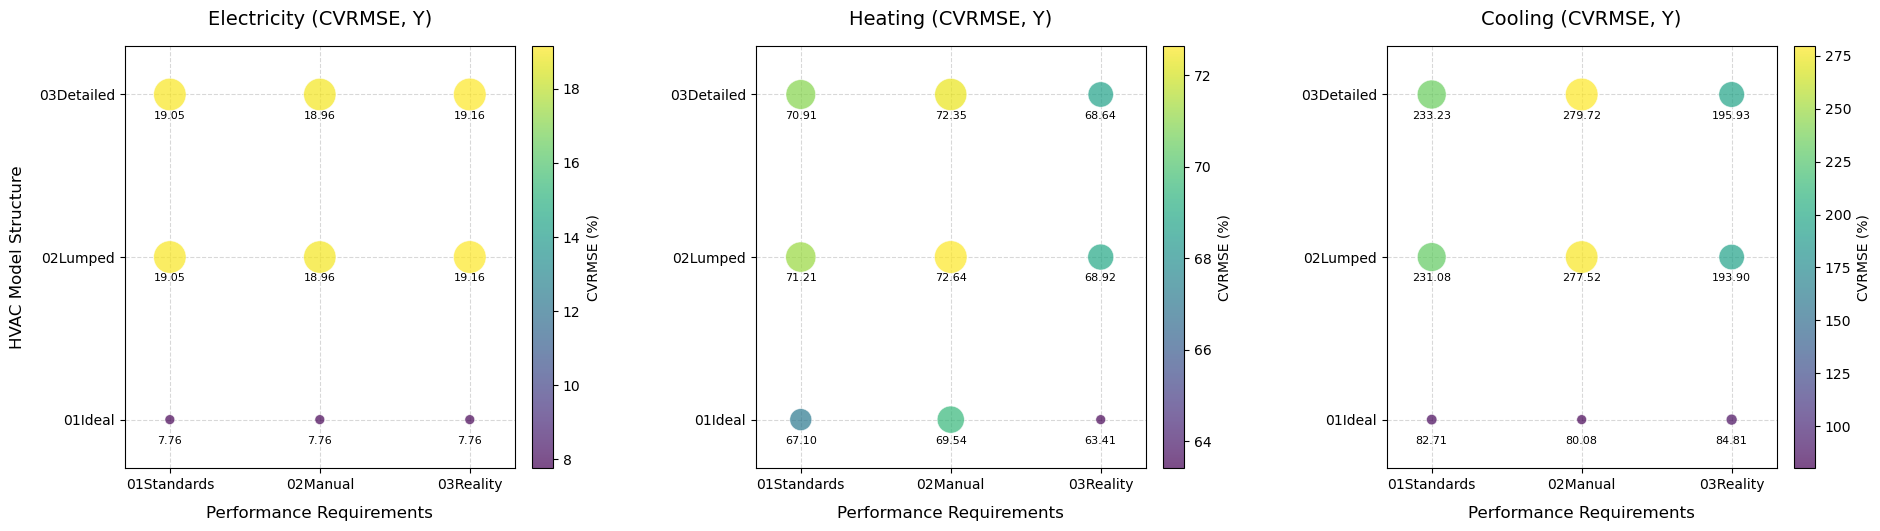

<Figure size 640x480 with 0 Axes>

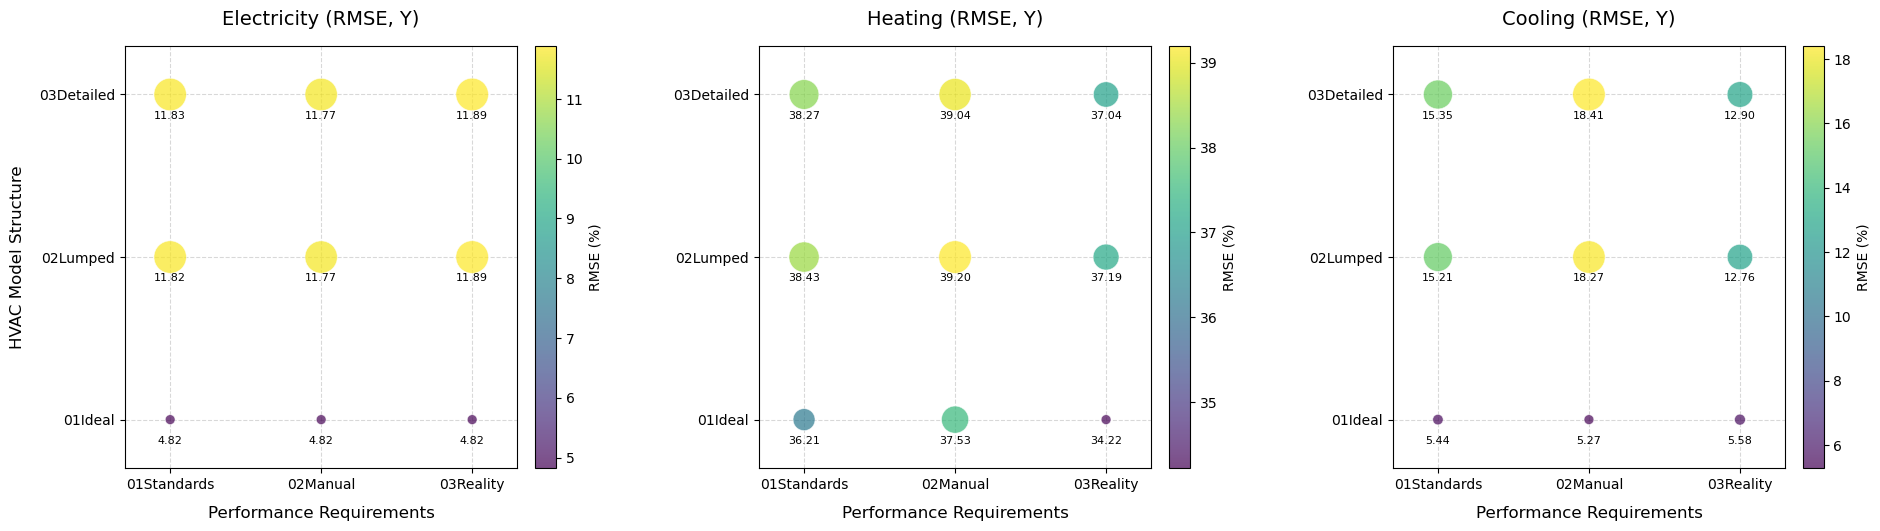

<Figure size 640x480 with 0 Axes>

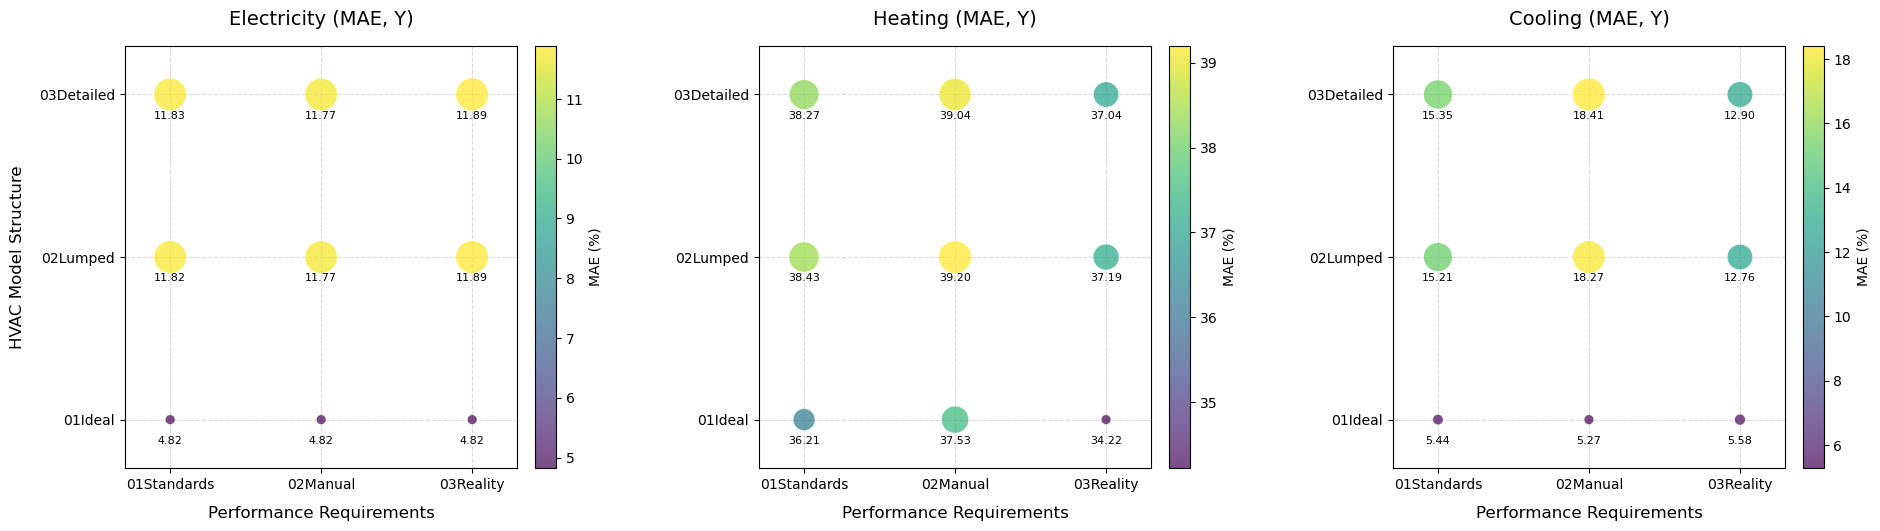

<Figure size 640x480 with 0 Axes>

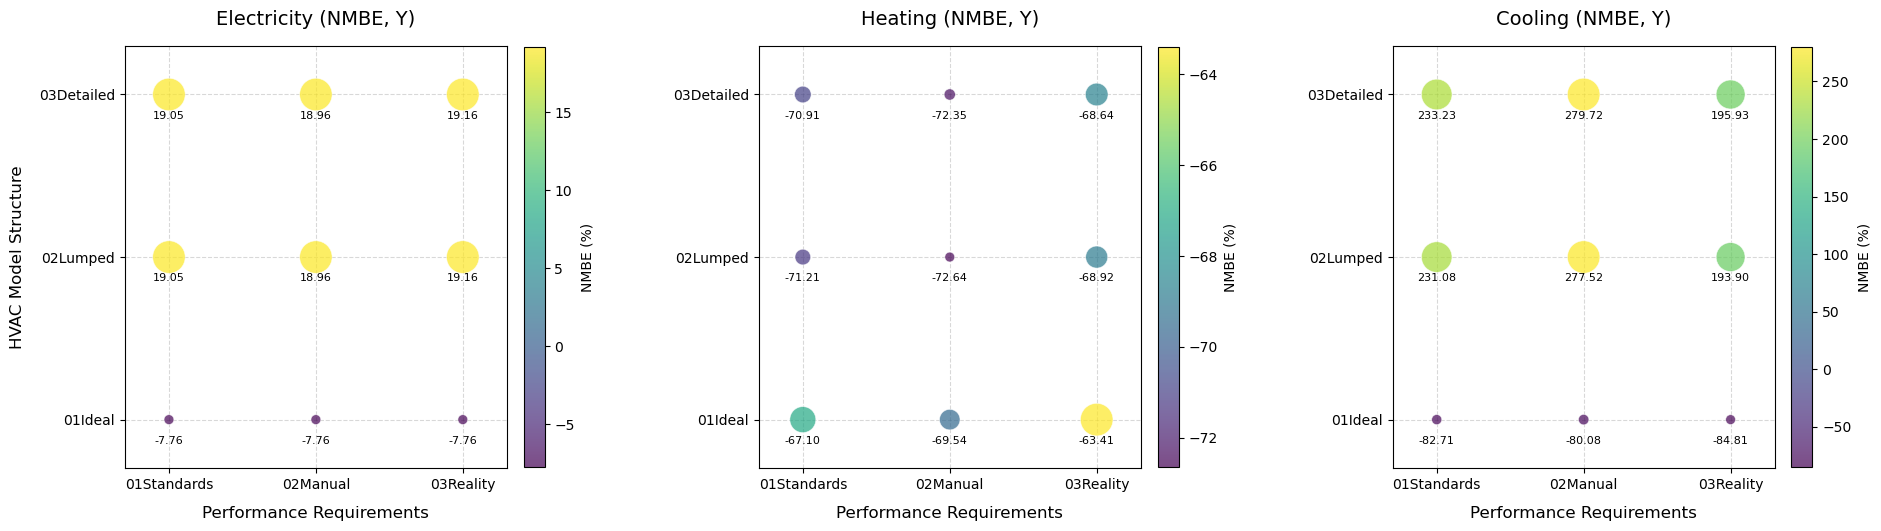

<Figure size 640x480 with 0 Axes>

In [107]:
kpi_dfs = {'CVRMSE': multifreq_cvrmse_df,'RMSE': multifreq_rmse_df,'MAE': multifreq_mae_df,'NMBE': multifreq_nmbe_df}
for kpi_name, df in kpi_dfs.items():
    kpi_dfs[kpi_name] = df[sorted(df.columns, key=sort_key)]

for kpi_name, df in kpi_dfs.items():
    plot_2d_kpi_visualization(
        df, 
        simulation_name_map, 
        granularity_filter=['y'], 
        kpi_name=kpi_name
    )